# Praca domowa nr 5
Adrianna Grudzień\
14.05.2021 r.

W ramach pracy domowej z przedmiotu Wstęp do uczenia maszynowego przetestowałam 2 metody klasteryzujące. Następnie wybrałam optymalną liczbę klastrów. W każdej metodzie wykorzystałam inny sposób wybierania optymalnej liczby klastrów.

W realizacji zadania wykorzystałam zbiór danych **clustering.csv**.

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig_size = 6, 4

In [2]:
df = pd.read_csv('clustering.csv', header=None)
df.head()

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


<AxesSubplot:xlabel='0', ylabel='1'>

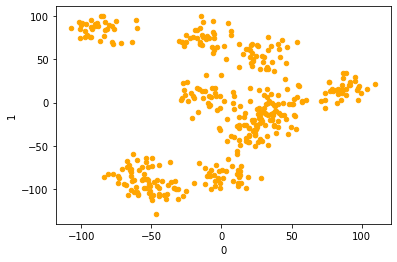

In [73]:
df.plot.scatter(0,1, c="orange")

## Metoda `k-średnich`
Na podstawie wcześniejszego wykresu możemy intuicyjnie przewidzieć zadowalająco dobrą liczbę klastrów. Na początek przyjmijmy, że jest to k=8 (tyle wyraźnie oddzielonych obszarów widzę).

In [111]:
from sklearn.cluster import KMeans

# funkcja z materiałów z zajęć
def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.figure(figsize = fig_size)

    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='magma')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters n_clusters = ' + str(n_clusters))
    plt.show()

Musimy jeszcze zmienić typ wprowadzanych danych (przy pomocy funkcji *to_numpy()*. Dlatego tworzę nowy obiekt X.

In [58]:
X = df.to_numpy()

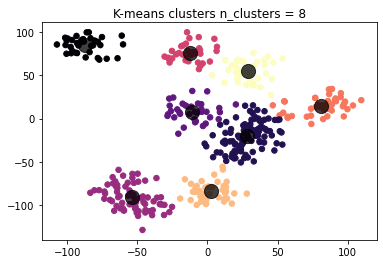

In [112]:
plot_kmeans_clusters(X, 8)

Podział wydaje się w porządku - liczba klastrów nie jest za duża, a ich rozłączność jest wyraźna.

Być może jednak k=8 nie jest najlepszym wyborem. Aby to sprawdzić, zastosuję metodę łokci.

In [5]:
# funkcja z materiałów z zajęć:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

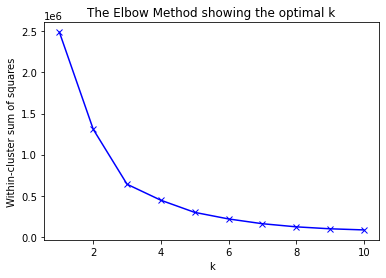

In [11]:
# funkcja z materiałów z zajęć
wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Teoretycznie należałoby wybrać takie k, gdzie 'score' zaczyna maleć w bardzo powolny sposób. Jest to wybór subiektywny i na moje oko może to być k=5. Sprawdźmy ten podział.

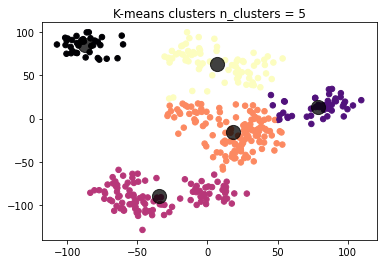

In [113]:
plot_kmeans_clusters(X, 5)

Podział wygląda sensownie. Udało się zmniejszyć liczbę klastrów z zachowaniem całkiem wyraźnych granic.

In [6]:
# funkcja z materiałów z zajęć
def count_clustering_scores(X, cluster_num, model_class, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_class(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

## Miara min_interclust_dist

In [89]:
from scipy.spatial import distance

# funkcja z materiałów z zajęć
def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

In [137]:
def rysujWykres(X, k):
    minDistances = []
    for i in range(1, k+1):
        minDistances.append(count_clustering_scores(X, i, KMeans, min_interclust_dist))
    plt.plot(range(1, len(minDistances)+1), minDistances)
    plt.xlabel('n_cluster')
    plt.ylabel('min_interclust_dist')
    plt.title('min_interclust_dist for n_cluster')
    plt.show()

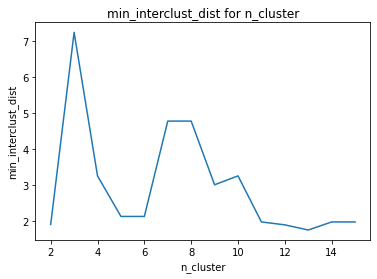

In [138]:
rysujWykres(X,15)

Im większy minimalny dystans między klastrami, tym podział jest lepszy. Na podstawie powyższego wykresu możemy wnioskować, że największy wynik jest osiągany dla k=3. Na drugim miejscu znajdują się k=7 oraz k=8 z takim samym wynikiem. Spójrzmy na nie.

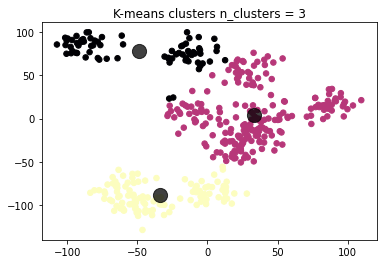

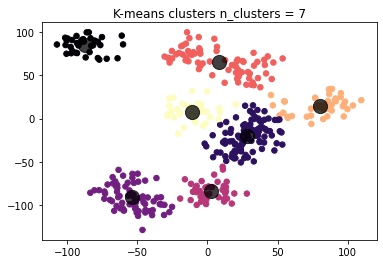

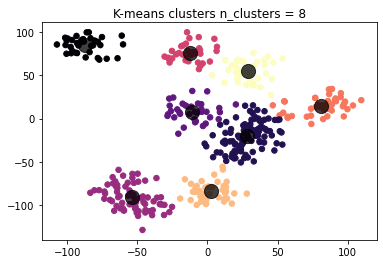

In [114]:
plot_kmeans_clusters(X, 3)
plot_kmeans_clusters(X, 7)
plot_kmeans_clusters(X, 8)

Wszystkie z tych podziałów wyglądają dobrze. Zostałabym jednak przy k=8, ponieważ w przypadku k=3 i k=7 klastry wydają się bardziej wewnętrznie rozbite.

## AgglomerativeClustering
W tej sekcji spróbuję dobrać optymalny parametr `linkage` w modelu AgglomerativeClustering z liczbą klastrów k=8. Może on przyjmować następujące wartości: {'ward', 'complete', 'average', 'single'}. Wypróbuję każdy z nich.

In [129]:
from sklearn.cluster import AgglomerativeClustering

def plot_agglomerative_clustering(X, k, linkage):
    model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    y_pred = model.fit_predict(X)
    f = plt.figure(figsize=fig_size)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=30, cmap='magma')
    plt.title('K-means; n_clusters = ' + str(k) + '; linkage = ' + str(linkage) )
    plt.show()

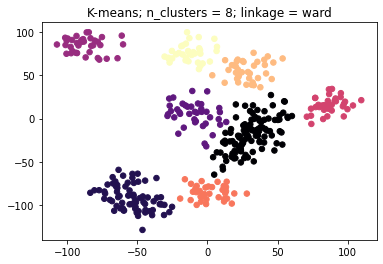

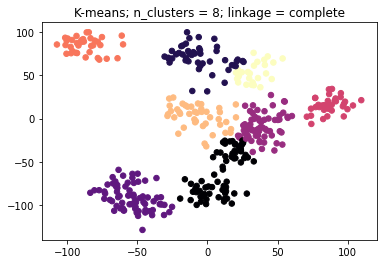

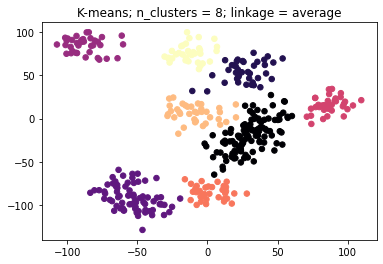

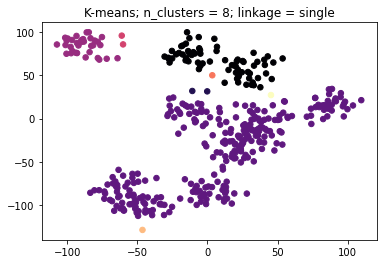

In [130]:
plot_agglomerative_clustering(X, 8, 'ward')
plot_agglomerative_clustering(X, 8, 'complete')
plot_agglomerative_clustering(X, 8, 'average')
plot_agglomerative_clustering(X, 8, 'single')

Niezaprzeczalnie linkage = {'complete', 'single'} wyglądają beznadziejnie, 'average' wygląda prawie dobrze, ma jednak dosyć rozproszone klastry. Dla `'ward'` wszystko wygląda w porządku, dlatego właśnie tę wartość parametru linkage uznaję za najlepszą w tym przypadku.

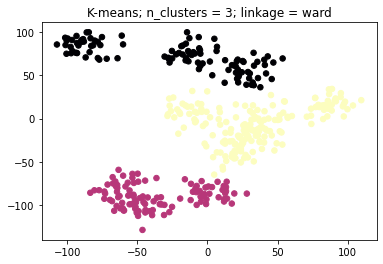

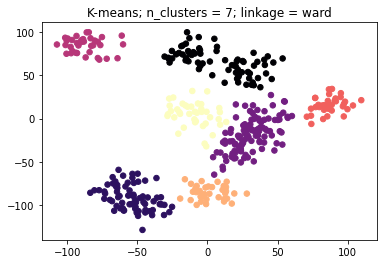

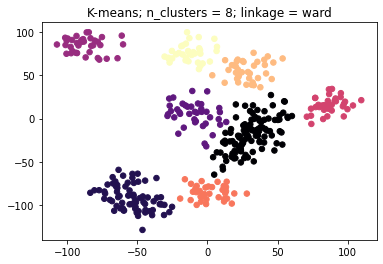

In [134]:
plot_agglomerative_clustering(X, 3, 'ward')
plot_agglomerative_clustering(X, 7, 'ward')
plot_agglomerative_clustering(X, 8, 'ward')

W tym przypadku również wychodzi na to, że najlepszy podział występuje dla k=8. W pozostałych przypadkach klastry są rozproszzone.

## Podsumowanie
Po przeprowadzeniu licznych doświadczeń dochodzę do wniosku, że początkowy (subiektywny i intuicyjny) wybór liczby klastrów k=8 był słuszny.